In [ ]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset


# Paramètres
train_ratio = 0.8  # 80% des images pour train, 20% pour test
batch_size = 32  # Taille des batchs

# Définition des transformations (redimensionnement, normalisation, etc.)
transform = transforms.Compose([
    transforms.Resize((185, 185)),  # Redimensionne toutes les images à 185*185
    transforms.ToTensor(),  # Convertit en tenseur PyTorch
])

# TO DO : test with transform suivant 

# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.Lambda(lambda img: img.convert('L') if img.mode == 'RGB' else img),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))
# ])


# Chargement des données
dataset_path = "../MovieGenre/content/sorted_movie_posters_paligema"
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Création du DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Affichage des classes
print(dataset.classes)  # Affichera ["action", "comedie", "drame"]

# Séparer les indices des images par classe
class_indices = {cls_idx: [] for cls_idx in range(len(dataset.classes))}

# Remplir les listes d'indices pour chaque classe
for idx, (_, label) in enumerate(dataset):
    class_indices[label].append(idx)

# Split train/test pour chaque classe
train_indices, test_indices = [], []

for cls_idx, indices in class_indices.items():
    split_point = int(len(indices) * train_ratio)  # 80% pour train
    train_indices.extend(indices[:split_point])
    test_indices.extend(indices[split_point:])

# Création des sous-ensembles train et test
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

# Création des DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Vérification
print(f"Train: {len(train_dataset)} images")
print(f"Test: {len(test_dataset)} images")


['action', 'animation', 'comedy', 'documentary', 'drama', 'fantasy', 'horror', 'romance', 'science Fiction', 'thriller']
Train: 4297 images
Test: 1078 images


In [4]:
images, labels = next(iter(dataloader))

# # print(images.shape)  # (batch_size, channels, height, width)
# # print(labels)  # Liste des indices correspondant aux classes


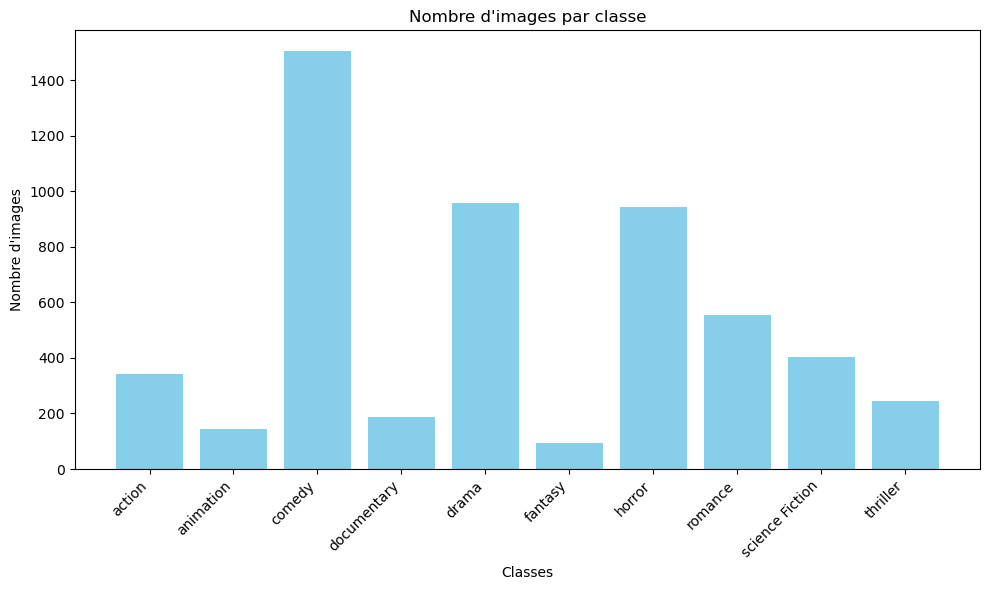

In [5]:
import matplotlib.pyplot as plt
from collections import Counter

# Compter le nombre d'images par classe dans le dataset
class_counts = Counter([label for _, label in dataset])

# Obtenir les noms des classes (en supposant que `dataset.classes` contient les noms des classes)
class_names = dataset.classes

# Obtenir le nombre d'images par classe
counts = [class_counts[i] for i in range(len(class_names))]

# Tracer le bar graph
plt.figure(figsize=(10, 6))
plt.bar(class_names, counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Nombre d\'images')
plt.title('Nombre d\'images par classe')
plt.xticks(rotation=45, ha='right')  # Rotation des labels pour une meilleure lisibilité
plt.tight_layout()
plt.show()


In [3]:
# for img, label in zip(images, labels):
#     print(f"Label : {dataset.classes[label]}")


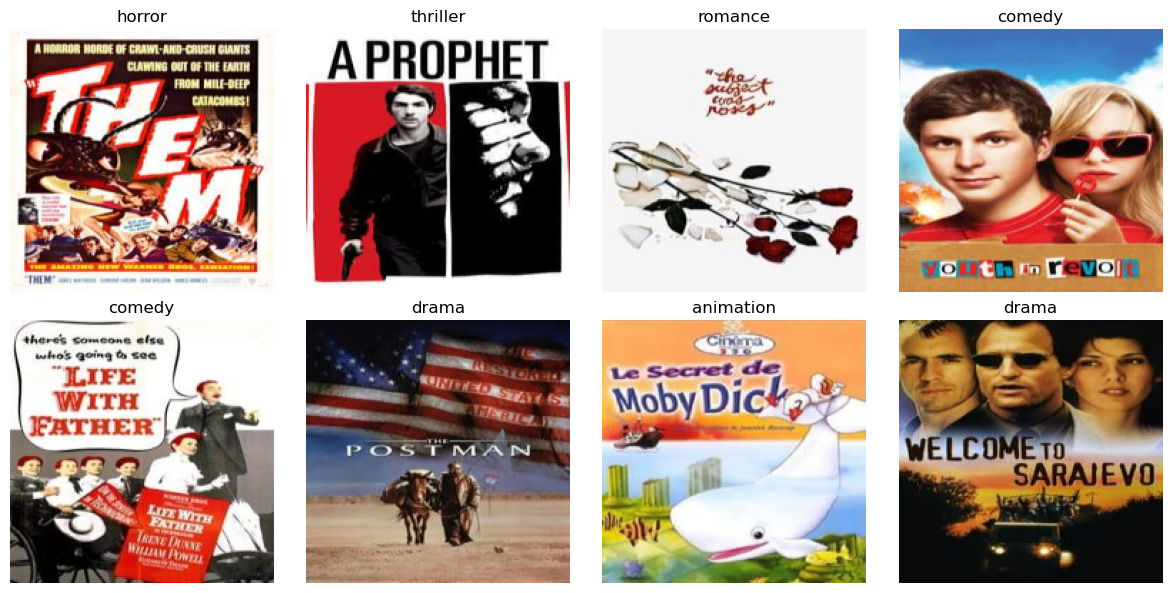

In [6]:
# Affichage des images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))  # Grille 2x4
axes = axes.flatten()

for img, label, ax in zip(images, labels, axes):
    img = img.permute(1, 2, 0).numpy()  # Convertir le tenseur en image affichable
    ax.imshow(img)
    ax.set_title(dataset.classes[label])  # Afficher le nom du genre du film
    ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

mobilenet = models.mobilenet_v3_small(pretrained=True)
resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Modifier la dernière couche pour s'adapter à ton nombre de classes
num_classes = len(dataset.classes)  # Nombre de genres de films
mobilenet.classifier[-1] = nn.Linear(mobilenet.classifier[-1].in_features, num_classes)

# Envoyer le modèle sur GPU (si disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet = mobilenet.to(device)

/home/besbesines/miniforge3/envs/optim/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/besbesines/miniforge3/envs/optim/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /home/besbesines/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 38.5MB/s]
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/be

In [8]:
mobilenet = mobilenet.eval()

In [9]:
x = torch.zeros(32,3,185,185).cuda()
y = mobilenet(x)
y.shape

torch.Size([32, 10])

In [12]:
from tqdm import tqdm

# Définition de la fonction de perte et de l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet.parameters(), lr=0.001)

# Nombre d'epoch
num_epochs = 2

# Pour stocker la perte et l'accuracy
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Boucle d'entraînement
for epoch in range(num_epochs):
    mobilenet.train()  # Mode entraînement
    running_loss = 0.0
    correct = 0
    total = 0

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Réinitialisation des gradients
        outputs = mobilenet(images)  # Prédictions
        loss = criterion(outputs, labels)  # Calcul de la perte
        loss.backward()  # Backpropagation
        optimizer.step()  # Mise à jour des poids

        running_loss += loss.item()

        # Calcul de l'accuracy
        _, predicted = torch.max(outputs, 1)  # Prédictions max
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        train_loader_tqdm.set_postfix(loss=loss.item(), acc=100 * correct / total)

    # Stockage des valeurs pour affichage
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Affichage de la perte et de l'accuracy après chaque epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    # Calcul de la perte et de l'accuracy sur le dataset de test
    mobilenet.eval()  # Mode évaluation
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():  # Pas de calcul de gradients pendant l'évaluation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = mobilenet(images)
            loss = criterion(outputs, labels)  # Calcul de la perte pour le test
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)  # Moyenne de la perte sur le dataset de test
    test_acc = 100 * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    print(f"Accuracy sur le test: {test_acc:.2f}%, Perte sur le test: {test_loss:.4f}")


# Save model weights
torch.save(mobilenet.state_dict(), 'mobilnet.pth')

Epoch 1/2: 100%|██████████| 135/135 [00:11<00:00, 11.35it/s, acc=57.1, loss=1.03] 


Epoch [1/2] - Loss: 1.2226, Accuracy: 57.09%
Accuracy sur le test: 34.88%, Perte sur le test: 1.9574


Epoch 2/2: 100%|██████████| 135/135 [00:11<00:00, 11.33it/s, acc=68.6, loss=1.53] 


Epoch [2/2] - Loss: 0.8858, Accuracy: 68.61%
Accuracy sur le test: 36.18%, Perte sur le test: 2.2877


In [ ]:
# Affichage de la loss et de l'accuracy
epochs = range(1, num_epochs + 1)

# Plotting
plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Perte sur le train')
plt.plot(epochs, test_losses, label='Perte sur le test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss pendant l\'entraînement')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Accuracy sur le train')
plt.plot(epochs, test_accuracies, label='Accuracy sur le test')
plt.xlabel('Époque')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy pendant l\'entraînement et sur le test')
plt.legend()

plt.tight_layout()
plt.show()